# RoI Pooling

Implement a ROI Pooling operator. Your code will be given the following variables:

* *input*, a mini-batch of feature maps (a torch.Tensor with shape (n, C, H, W) and dtype torch.float32)

* *boxes*, a list of bounding box coordinates on which you need to perform the ROI Pooling. *boxes* will be a list of (L,4) torch.Tensor with dtype torch.float32, where *boxes[i]* will refer to the i-th element of the batch, and contain *L* coordinates in the format (y1, x1, y2, x2)

* a tuple of integers *output_size*, containing the number of cells over which pooling is performed, in the format (heigth, width)

The code should produce an output torch.Tensor *out* with dtype torch.float32 and shape (n, L, C, output_size[0], output_size[1]).

In [157]:
import random
import torch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle


n = random.randint(1, 3)
C = random.randint(10, 20)
H = 6# random.randint(5, 10)
W = 4# random.randint(5, 10)
oH = random.randint(2, 4)
oW = random.randint(2, 4)
L = random.randint(2, 6)  #number of boxes foreach map
input = torch.rand(n, C, H, W)
boxes = [torch.zeros(L, 4) for _ in range(n)]
for i in range(n):
  boxes[i][:, 0] = torch.rand(L) * (H-oH)       # y
  boxes[i][:, 1] = torch.rand(L) * (W-oW)       # x
  boxes[i][:, 2] = oH + torch.rand(L) * (H-oH)  # w
  boxes[i][:, 3] = oW + torch.rand(L) * (W-oW)  # h

  boxes[i][:,2:] += boxes[i][:,:2]
  boxes[i][:,2] = torch.clamp(boxes[i][:,2], max=H-1)
  boxes[i][:,3] = torch.clamp(boxes[i][:,3], max=W-1)
output_size = (oH, oW)


print("H:", H, "W:", W)
print(output_size)

H: 6 W: 4
(2, 3)


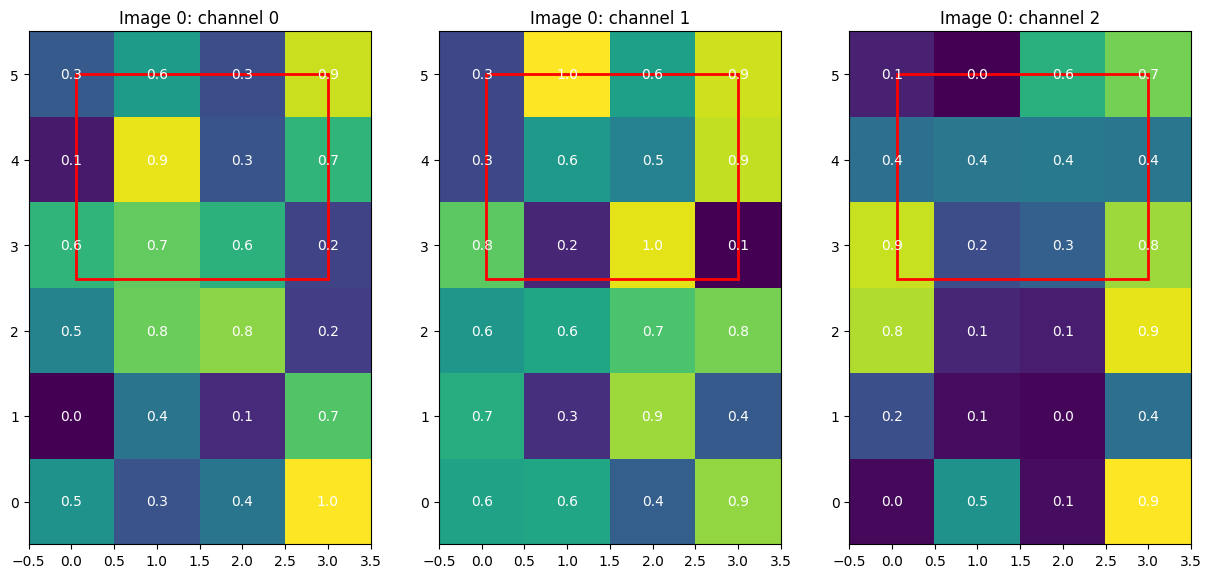

In [158]:
#let's show an example

def showMapsAndBoxes(maps:torch.Tensor, boxes:torch.Tensor, highlightCorners=False):
    """Mamps should have shape (C,H,W)"""
    numChannels = 3

    fig, ax = plt.subplots(1,numChannels,figsize=(15, 15))
    for i in range(min(maps.shape[0],numChannels)):
        example = maps[i]
        im = ax[i].imshow(example)

        #let's print boxes
        for b in boxes:
            dims = b
            x=dims[1]
            y=dims[0]
            w=dims[3] - dims[1]
            h=dims[2] - dims[0]
            ax[i].add_patch(Rectangle((x, y), w, h, fc ='none', ec ='red', lw = 2) )

            if highlightCorners:
                cornerColor='orange'
                ax[i].add_patch(Circle((x,y),0.2, fc ='none', ec =cornerColor , lw = 2))
                ax[i].add_patch(Circle((x+w,y),0.2, fc ='none', ec =cornerColor , lw = 2))
                ax[i].add_patch(Circle((x,y+h),0.2, fc ='none', ec =cornerColor , lw = 2))
                ax[i].add_patch(Circle((x+w,y+h),0.2, fc ='none', ec =cornerColor , lw = 2))

        # let's write cell values
        for k in range(example.shape[0]):
            for j in range(example.shape[1]):
                value = '%.1f' % example[k, j]
                text = ax[i].text(j, k, value,
                            ha="center", va="center", color="w")
        ax[i].set_title("Image 0: channel " + str(i))
        ax[i].set_ylim(ax[i].get_ylim()[::-1]) #reversing y axis orientation

    plt.show()


showMapsAndBoxes(input[0],boxes[0][0].unsqueeze(0))

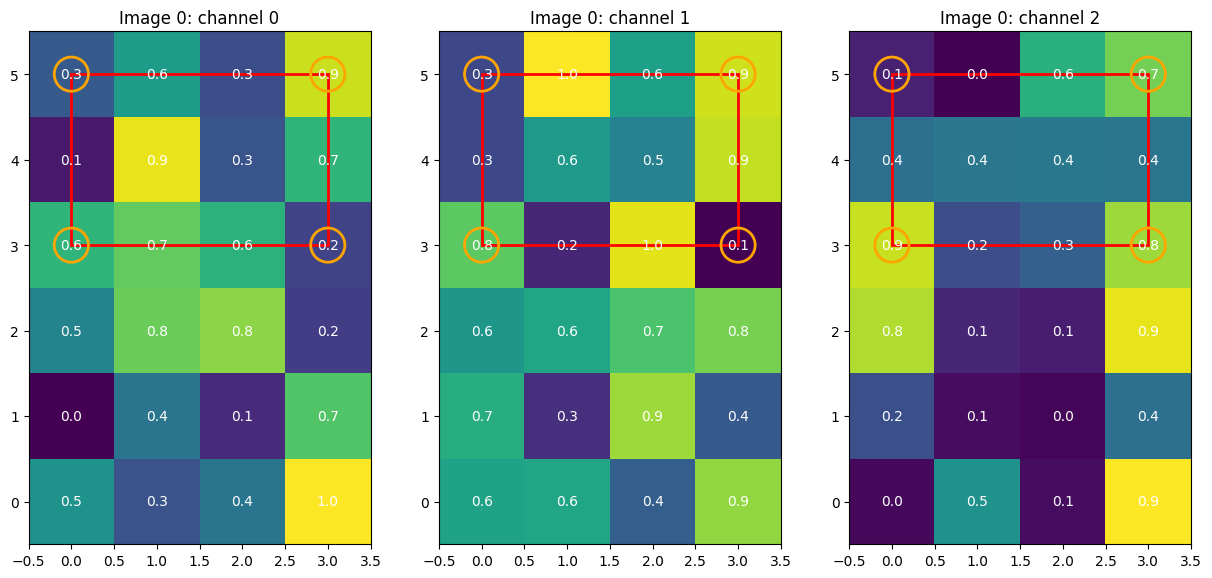

In [159]:
#lets align boxes coordinates
aligned = boxes.copy()
for i, el in enumerate(aligned):
    aligned[i] = torch.round(el)

showMapsAndBoxes(input[0],aligned[0][0].unsqueeze(0),True)


In [ ]:
#now lets split a box in (oH,oW) integer subregiorns

def getSubRegions(box:torch.Tensor, output_W:int, output_H:int):
    x = box[1]
    y = box[0]
    w = box[3] - box[1]
    h = box[2] - box[0]

    #returns a list of (index) subregions
